# 1 概述

再来回忆一下我们的终极目标，我们的终极目标是搭建一个人脸识别的模型，经过之前的努力，我们已经训练出来了一个人脸检测模型，然后我们就可以利用检测到的人脸，将其输入人脸识别模型中，来达到人脸识别的目的。

现在有一个问题，之前的人脸检测模型是通过darknet平台实现的，但是接下来的人脸识别模型我们不会使用darknet网络了，而会使用keras+tensorflow，为了整个模型的灵活性，也为了更好的管理人脸识别模型，我们需要将darknet移植出来，用Python来实现。当然并不会抑制整个darknet平台，仅仅移植和YOLO相关的部分，当然，我也不会自己动手去移植，因为已经有人已经帮助我们做好了这些事情！

所以接下来，我们将使用[YAD2K](https://github.com/allanzelener/YAD2K)这个开源工程，其实就是darknet的Python版本，但是支持的模型仅仅是类YOLO的模型（tiny-yolo等）。

所以darknet在本项目中就是为了训练YOLO人脸检测模型的权重，然后我们利用YAD2K来搭建YOLO人脸检测模型，加载权重。最后再搭建人脸识别模型。

# 2 YAD2K

本项目就是基于[YAD2K](https://github.com/allanzelener/YAD2K)上进行开发的，所以你没必要再去克隆。再声明一点，本notebook就位于YAD2K内。

接下来我们就来走一遍YAD2K的流程，看看他到底做了哪些事情。然后我们再提取我们需要的部分来搭建YOLO模型！

## 2.1 YAD2K运行环境搭建

首先根据YAD2K的使用说明来搭建环境，输入如下命令

    git clone https://github.com/allanzelener/yad2k.git
    cd yad2k
    
    ## 为了方便，作者把yad2k的环境信息都放在了environment.yml文件里面，运行下面的命令创建环境
    conda env create -f environment.yml
    source activate yad2k
    
    # 安装一些常用的库
    pip install numpy h5py pillow
    # 安装GPU版本的tensorflow，如果没有GPU的话，安装CPU版本的也可以，就是CPU版本的预测的速度要慢很多
    pip install tensorflow-gpu  # CPU-only: conda install -c conda-forge tensorflow
    pip install keras # Possibly older release: conda install keras

## 2.2 YOLO模型配置文件以及权重

就像之前[第二个notebook](https://github.com/rikichou/yolo/blob/master/YOLO_face_detection_and_recognition_2--train_yolo_on_CelebA_datasheet.ipynb)说的那样，darknet需要一个模型的配置文件和权重才能把模型搭建起来，同理，对于YAD2K也需要这两样东西。

    1，YOLO模型配置文件，本git已经自带，位于cfg/yolov2-celeba.cfg
    2，权重文件是我们在CelebA数据集上训练的权重，有大概200M，我放在了另一个仓库里面，记得克隆前要安装git LFS
        git lfs clone https://github.com/rikizhou/yolo_face_weights.git
      下载完了把它拷贝到weights目录下就可以了

## 2.3 转换darknet模型

在上一步中，我们获得darknet下载YOLO模型的配置文件和权重，这两样东西包含了搭建模型需要的全部东西。现在我们就根据这两样东西，将darknet模型转换为keras模型。

注意注意！各位同学！！！这里需要更改源码的一个BUG，在yad2k.py，在第 83 行，将 buffer=weights_file.read(16) 改为 buffer=weights_file.read(20)，否则会出现权重错位，导致模型完全错误！当然，在本项目中，已经更改好了！

./yad2k.py cfg/yolov2-celeba.cfg weights/yolov2-celeba_5000.weights model_data/yolo_face_detectoin.h5

运行了之后，会在model_data目录下生成yolo_face_detectoin_anchors.txt文件

## 2.4 预测测试图片

YAD2K是利用test_yolo.py这个文件来实现预测的，所以我们应该查看其源代码，分析该脚本需要提供什么参数？
    
    model_path：keras模型的路径，model_data/yolo_face_detectoin.h5
    --anchors_path：我们需要指定anchors文件的路径，model_data/yolo_face_detectoin_anchors.txt
    --classes_path：类别文件的路径，里面指定了每个类别的名字，我们就只有一个face，model_data/celeba_classes.txt
    --test_path：输入的测试图片的路径，默认是在images目录下，我们就用默认的就好了
    --output_path：输出的测试图片的路径，默认在images/out，我们就用默认
    --score_threshold：将每个anchors的pc乘以该anchors的类别概率就等于scores，对于YOLO模型的预测输出，如果某个anchors的score小于score_threshold，那么该anchors的预测将直接会被删除，不会参与IOU的流程。默认为0.3，我们暂时使用0.3，然后根据效果来调节该阈值。
    --iou_threshold：IOU的阈值，在执行非最大值抑制（NMS）的时候，如果两个同类预测的bbox的IOU>iou_threshold，那么就认为该对象被重复检测了，需要删除几率小的那个Bbox。默认为0.5，我们暂时使用0.5，然后根据效果来调节该阈值。
    
如果我上面说的这些大家不懂的话，那么可能需要看关于YOLO的视频了，这里推荐吴恩达教授Coursera上的DeepLearning.ai系列课程，在CNN部分讲解了YOLO的详细流程。

接下来我们就要预测一下images里面的图片，输出的结果在images/out文件夹里面

./test_yolo.py model_data/yolo_face_detectoin.h5 -a model_data/yolo_face_detectoin_anchors.txt -c model_data/celeba_classes.txt

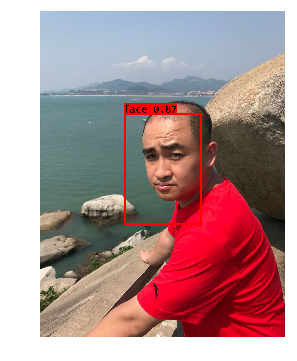

In [101]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
img_path = "images/out/saofei1.png"

plt.figure(figsize=(6,6))

img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

# 3 我们需要怎样的接口

经过上面的对图片的预测，我们可以基本判定我们需要什么样的接口了，一个接口用于根据传入的配置创建模型，另一个接口用于预测输入的图片，输出图片的所有的bounding box以及所有的bounding box属于脸的概率。

所以，我们可以创建一个类，如下代码：

In [2]:
import configparser
import io
import os
from collections import defaultdict
import colorsys
import imghdr
import random
import numpy as np
from keras import backend as K
K.set_image_data_format('channels_last')
from PIL import Image, ImageDraw, ImageFont

from keras.layers import (Conv2D, GlobalAveragePooling2D, Input, Lambda,
                          MaxPooling2D)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model as plot
from yad2k.models.keras_yolo import yolo_eval, yolo_head
from yad2k.models.keras_yolo import (space_to_depth_x2,
                                     space_to_depth_x2_output_shape)
 
default_config_path = "cfg/yolov2-celeba.cfg"
default_weights_path = "weights/yolov2-celeba_5000.weights"
default_anchors_path = "model_data/yolo_face_detectoin_anchors.txt"
default_classes_path = "model_data/celeba_classes.txt"
default_score_threshold = 0.3
default_iou_threshold = 0.5

class Detector(object):
    def __init__(self, config_path=default_config_path, weights_path=default_weights_path, anchors_path=default_anchors_path, \
                 classes_path = default_classes_path, score_threshold=default_score_threshold, iou_threshold=default_iou_threshold):
        self.config_path = config_path
        self.weights_path = weights_path
        self.anchors_path = anchors_path
        self.classes_path = classes_path
        self.sess = K.get_session()
        self.iou_threshold = iou_threshold
        self.score_threshold = score_threshold
        
        output_root = "model_data"
        print('Loading weights.')
        
        # Load weights and config.
        weights_file = open(weights_path, 'rb')
        weights_header = np.ndarray(
            shape=(4, ), dtype='int32', buffer=weights_file.read(20))
        
        unique_config_file = self.unique_config_sections(self.config_path)
        cfg_parser = configparser.ConfigParser()
        cfg_parser.read_file(unique_config_file)
        
        image_height = int(cfg_parser['net_0']['height'])
        image_width = int(cfg_parser['net_0']['width'])
        self.image_height = image_height
        self.image_width = image_width
        prev_layer = Input(shape=(image_height, image_width, 3))
        all_layers = [prev_layer]

        weight_decay = float(cfg_parser['net_0']['decay']
                             ) if 'net_0' in cfg_parser.sections() else 5e-4
        count = 0
        
        for section in cfg_parser.sections():
            print('Parsing section {}'.format(section))
            if section.startswith('convolutional'):
                filters = int(cfg_parser[section]['filters'])
                size = int(cfg_parser[section]['size'])
                stride = int(cfg_parser[section]['stride'])
                pad = int(cfg_parser[section]['pad'])
                activation = cfg_parser[section]['activation']
                batch_normalize = 'batch_normalize' in cfg_parser[section]

                # padding='same' is equivalent to Darknet pad=1
                padding = 'same' if pad == 1 else 'valid'

                # Setting weights.
                # Darknet serializes convolutional weights as:
                # [bias/beta, [gamma, mean, variance], conv_weights]
                prev_layer_shape = K.int_shape(prev_layer)

                # TODO: This assumes channel last dim_ordering.
                weights_shape = (size, size, prev_layer_shape[-1], filters)
                darknet_w_shape = (filters, weights_shape[2], size, size)
                weights_size = np.product(weights_shape)

                print('conv2d', 'bn'
                      if batch_normalize else '  ', activation, weights_shape)

                conv_bias = np.ndarray(
                    shape=(filters, ),
                    dtype='float32',
                    buffer=weights_file.read(filters * 4))
                count += filters

                if batch_normalize:
                    bn_weights = np.ndarray(
                        shape=(3, filters),
                        dtype='float32',
                        buffer=weights_file.read(filters * 12))
                    count += 3 * filters

                    # TODO: Keras BatchNormalization mistakenly refers to var
                    # as std.
                    bn_weight_list = [
                        bn_weights[0],  # scale gamma
                        conv_bias,  # shift beta
                        bn_weights[1],  # running mean
                        bn_weights[2]  # running var
                    ]

                conv_weights = np.ndarray(
                    shape=darknet_w_shape,
                    dtype='float32',
                    buffer=weights_file.read(weights_size * 4))
                count += weights_size

                # DarkNet conv_weights are serialized Caffe-style:
                # (out_dim, in_dim, height, width)
                # We would like to set these to Tensorflow order:
                # (height, width, in_dim, out_dim)
                # TODO: Add check for Theano dim ordering.
                conv_weights = np.transpose(conv_weights, [2, 3, 1, 0])
                conv_weights = [conv_weights] if batch_normalize else [
                    conv_weights, conv_bias
                ]

                # Handle activation.
                act_fn = None
                if activation == 'leaky':
                    pass  # Add advanced activation later.
                elif activation != 'linear':
                    raise ValueError(
                        'Unknown activation function `{}` in section {}'.format(
                            activation, section))

                # Create Conv2D layer
                conv_layer = (Conv2D(
                    filters, (size, size),
                    strides=(stride, stride),
                    kernel_regularizer=l2(weight_decay),
                    use_bias=not batch_normalize,
                    weights=conv_weights,
                    activation=act_fn,
                    padding=padding))(prev_layer)

                if batch_normalize:
                    conv_layer = (BatchNormalization(
                        weights=bn_weight_list))(conv_layer)
                prev_layer = conv_layer

                if activation == 'linear':
                    all_layers.append(prev_layer)
                elif activation == 'leaky':
                    act_layer = LeakyReLU(alpha=0.1)(prev_layer)
                    prev_layer = act_layer
                    all_layers.append(act_layer)

            elif section.startswith('maxpool'):
                size = int(cfg_parser[section]['size'])
                stride = int(cfg_parser[section]['stride'])
                all_layers.append(
                    MaxPooling2D(
                        padding='same',
                        pool_size=(size, size),
                        strides=(stride, stride))(prev_layer))
                prev_layer = all_layers[-1]

            elif section.startswith('avgpool'):
                if cfg_parser.items(section) != []:
                    raise ValueError('{} with params unsupported.'.format(section))
                all_layers.append(GlobalAveragePooling2D()(prev_layer))
                prev_layer = all_layers[-1]

            elif section.startswith('route'):
                ids = [int(i) for i in cfg_parser[section]['layers'].split(',')]
                layers = [all_layers[i] for i in ids]
                if len(layers) > 1:
                    print('Concatenating route layers:', layers)
                    concatenate_layer = concatenate(layers)
                    all_layers.append(concatenate_layer)
                    prev_layer = concatenate_layer
                else:
                    skip_layer = layers[0]  # only one layer to route
                    all_layers.append(skip_layer)
                    prev_layer = skip_layer

            elif section.startswith('reorg'):
                block_size = int(cfg_parser[section]['stride'])
                assert block_size == 2, 'Only reorg with stride 2 supported.'
                all_layers.append(
                    Lambda(
                        space_to_depth_x2,
                        output_shape=space_to_depth_x2_output_shape,
                        name='space_to_depth_x2')(prev_layer))
                prev_layer = all_layers[-1]

            elif section.startswith('region'):
                with open('{}_anchors.txt'.format(output_root), 'w') as f:
                    print(cfg_parser[section]['anchors'], file=f)

            elif (section.startswith('net') or section.startswith('cost') or
                  section.startswith('softmax')):
                pass  # Configs not currently handled during model definition.

            else:
                raise ValueError(
                    'Unsupported section header type: {}'.format(section))
            
        self.model = Model(inputs=all_layers[0], outputs=all_layers[-1])
        print(self.model.summary())
        remaining_weights = len(weights_file.read()) / 4
        weights_file.close()
        print('Read {} of {} from Darknet weights.'.format(count, count +
                                                           remaining_weights))
        if remaining_weights > 0:
            print('Warning: {} unused weights'.format(remaining_weights))
    
        """
        =========================================================================
        """
        with open(self.classes_path) as f:
            class_names = f.readlines()
        self.class_names = [c.strip() for c in class_names]

        with open(self.anchors_path) as f:
            anchors = f.readline()
            anchors = [float(x) for x in anchors.split(',')]
            self.anchors = np.array(anchors).reshape(-1, 2)
        
        # Verify model, anchors, and classes are compatible
        num_classes = len(self.class_names)
        num_anchors = len(self.anchors)
        # TODO: Assumes dim ordering is channel last
        model_output_channels = self.model.layers[-1].output_shape[-1]
        assert model_output_channels == num_anchors * (num_classes + 5), \
            'Mismatch between model and given anchor and class sizes. ' \
            'Specify matching anchors and classes with --anchors_path and ' \
            '--classes_path flags.'
        
        ##### check if need
        # Check if model is fully convolutional, assuming channel last order.
        self.model_image_size = self.model.layers[0].input_shape[1:3]
        is_fixed_size = self.model_image_size != (None, None)

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                colors))
        random.seed(10101)  # Fixed seed for consistent colors across runs.
        random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
        random.seed(None)  # Reset seed to default.
        ##### check if need
        
        # Generate output tensor targets for filtered bounding boxes.
        # TODO: Wrap these backend operations with Keras layers.
        yolo_outputs = yolo_head(self.model.output, self.anchors, len(self.class_names))
        self.input_image_shape = K.placeholder(shape=(2, ))
        self.boxes, self.scores, self.classes = yolo_eval(
            yolo_outputs,
            self.input_image_shape,
            score_threshold=self.score_threshold,
            iou_threshold=self.iou_threshold)
        
    def predict(self, image):
        """
            input : np array, h,w,c
            return :
                out_boxes:all bounding boxes
                out_scores:all bounding box's score
                out_classes:all bounding box's classes
        """
        h, w, c = image.shape
        image_data = np.array(image, np.float32)
        image_data = cv2.resize(image_data, (self.image_height, self.image_width))
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
        
        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.model.input: image_data,
                self.input_image_shape: [h, w],
                K.learning_phase(): 0
            })
        
        #print('Found {} boxes for image'.format(len(out_boxes)))
        
        return out_boxes, out_scores, out_classes
        
        """
        crop_imgs = []
        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            top, left, bottom, right = box
            print (label + "top:{} left:{} bottom:{} right:{}".format(top, left, bottom, right))
            
            item = image[int(top):int(bottom), int(left):int(right), :]
            crop_imgs.append(item)
        return crop_imgs         
        """  
        
    def unique_config_sections(self, config_file):
        """Convert all config sections to have unique names.
        Adds unique suffixes to config sections for compability with configparser.
        """
        section_counters = defaultdict(int)
        output_stream = io.StringIO()
        with open(config_file) as fin:
            for line in fin:
                if line.startswith('['):
                    section = line.strip().strip('[]')
                    _section = section + '_' + str(section_counters[section])
                    section_counters[section] += 1
                    line = line.replace(section, _section)
                output_stream.write(line)
        output_stream.seek(0)
        return output_stream


/home/riki/anaconda3/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
a = Detector()

Loading weights.
Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)
Parsing section maxpool_0
Parsing section convolutional_1
conv2d bn leaky (3, 3, 32, 64)
Parsing section maxpool_1
Parsing section convolutional_2
conv2d bn leaky (3, 3, 64, 128)
Parsing section convolutional_3
conv2d bn leaky (1, 1, 128, 64)
Parsing section convolutional_4
conv2d bn leaky (3, 3, 64, 128)
Parsing section maxpool_2
Parsing section convolutional_5
conv2d bn leaky (3, 3, 128, 256)
Parsing section convolutional_6
conv2d bn leaky (1, 1, 256, 128)
Parsing section convolutional_7
conv2d bn leaky (3, 3, 128, 256)
Parsing section maxpool_3
Parsing section convolutional_8
conv2d bn leaky (3, 3, 256, 512)
Parsing section convolutional_9
conv2d bn leaky (1, 1, 512, 256)
Parsing section convolutional_10
conv2d bn leaky (3, 3, 256, 512)
Parsing section convolutional_11
conv2d bn leaky (1, 1, 512, 256)
Parsing section convolutional_12
conv2d bn leaky (3, 3, 256, 512)
Parsing section m

after non_max_suppression Tensor("Shape_6:0", shape=(1,), dtype=int32)
after gather Tensor("Shape_7:0", shape=(2,), dtype=int32)


In [4]:
import cv2
import matplotlib.pyplot as plt

img_path = "images/party.png"

img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

out_boxes, out_scores, out_classes = a.predict(img)

print (out_boxes)
#plt.imshow(crop_imgs[0])
#plt.axis("off")
#plt.show()

[[ 553.45465  393.8749   807.0062   616.781  ]
 [ 643.13983 1602.4414   822.28937 1753.8795 ]]


# 4 人脸识别

可以看到，上面的代码可以将图片中所有的人脸检测出来，现在我们就可以根据这些人脸来构建人脸的识别部分！

## 4.1 一个简短的教程

在人脸识别领域，通常有两个概念，一个是人脸验证，一个是人脸识别。

    人脸验证：输入一张图片和人名/ID，输出的结果是该图片是否和人名/ID匹配。
    
    人脸识别：输入一个图片，和有K个人的数据库进行匹配，输出和该输入匹配的ID或者无法识别。该问题要难于人脸验证，对于一个人脸验证的应用，有99%的正确率是可以接受的。但是如果要把该人脸验证用于人脸识别(100张人脸的数据库)的话，99%的验证正确率只能有37%左右的识别正确率，所以对于人脸识别来说，需要99.99%以及更高的验证成功率

### 4.1.1 one-shot 学习问题

也就是说在大多数人脸识别应用中，你需要仅仅通过一张图片，就能识别这个人，但是对于监督学习来说，只有一个训练样本的话，训练效果并不好。  

例如：
比如我们训练了一个模型，输入一张图片，输出101个softmax的结果，看看输入的这个人属于/不属于数据库中某个人的概率，但是实际上这样效果并不好。因为训练样本太少了。而且当有新人加入数据库的时候，此时你的模型的softmax的输出单元就变成了102，难道要重新训练整个卷积网络？  

所以我们需要的是学习一个差异性的函数，通过输入两张图片来输出一个差异值，如果差异值小于某个阈值τ，那么就是同一个人。

    distance = d(img1, img2)
    
    if distance < threshold：
        same person
    else：
        different person
这样的话，当要识别一个新人，只需要把他的图片加入到数据库中就行了。

### 4.1.2 Siamese网络

上一节了解到我们的d(img1, img2)函数的作用输入两张图片，输出这两张图片的差异值。实现这个功能的一个好的方式就是采用[Siamese](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf)网络了.

在我们平常看到的CNN中，一般是由若干卷积层加全连接层加softmax输出来构成的，现在我们不关注softmax层，将其去掉，那么就剩下了一个输出维度为比如128的全连接层，那么此时就相当于输入了一张图片，我们的CNN网络将其转换为了一个128维的向量，标记为f(x1)。这相当于图片x1的编码，将一张输入片表示成了一个128维的向量。如果此时有里那个一张输入的图片x2，那么这张图片对应的输出向量就是f(x1)。所以现在我们定义d(x1, x2)就相当于定义两个向量之间的差异！自然，在数学上有很多方式可以来表示两个向量的差异，我们这里使用两个向量之差的二阶范数的平方来表示。

    d(x1, x2) = L2 norm(f(x1) - f(x2))

这种通过运行同一个神经网络，来得到两个输入的两个输出向量，然后在比较这个输出向量的网络叫做Siamese网络。这里提到的思想都可以在[DeepFace: Closing the Gap to Human-Level Performance in Face Verification](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf)中找到。

所以我们现在学习的目的就是：
    
    如果x1,x2是同一个人的话，我们就要使得d(x1, x2)尽量小。反之，d(x1, x2)尽量大

### 4.1.3 Triplet loss

上面了解了学习目的，现在来介绍一下人脸识别的学习策略：我们会同时比较三张图片，这三张图片分别为anchor，positive，negative，anchor为基准图片，positive是和anchor同一个人的不同图片，negative是和anchor不同人的不同图片，所以现在的学习目标就是distance(anchor, positive) 远远小于 distance(anchor, negative)：

    d(A, P) - d(A, N) + margin <= 0
    
所以我们定义loss函数为：

    L(A,N,P) = max(d(A, P) - d(A, N) + margin, 0)
    
所以我们的训练数据集就是A,P,N这样的三元组，所以在训练集中，我们需要同一个人的多张照片组成A,P，然后再选择另一个人的照片N，构成一个三元组。而且对于三元组的选择也是有要求的，如果说随机地选择AP和N，那么这样会导致loss的条件很容易达成，模型将学不会足够有用的信息，我们应该选择P和AN很像，但是又不是同一个人的图片来构成三元组。也就是说d(A, N)很接近d(A, P),这样的话算法会竭尽全力使得d(A,P)小于d(A,N)。上述的观点很多都来自于[FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/abs/1503.03832)。

### 4.1.4 另一种人脸验证的模型--二分类模型

上面说了Siamese网络+triplet loss实现人脸验证功能。现在来介绍另一个模型，该模型同样采用Siamese网络，只是loss function采用的sigmoid。

同样是网络输入两张图片，分别得到两个128维的向量，然后将这两个向量相减，向量的结果的绝对值作为sigmoid函数的输入，然后输出为0--1之间，表示这两张图片是同一个人的概率。这里提到的思想都可以在[DeepFace: Closing the Gap to Human-Level Performance in Face Verification](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf)中找到。

## 4.2 just coding

首先我们需要搭建一个模型，该模型输入一张图片，输出一个128维的向量。接下来的代码借鉴了facenet的开源实现[openface](https://github.com/iwantooxxoox/Keras-OpenFace)，感兴趣的朋友可以去看看。

### 4.2.1 加载模型

facenet的模型采用了GoogleNet的inception block，相应的实现在inception_blocks.py里面也可以找到，感兴趣的可以看看。对于模型比较重要的几件事情就是

    1. 该网络采用了96*96维度的RGB图像作为输入，而且该模型采用channel first的方式，所以输入的tensor维度为(m, 3, 96, 96)
    2. 该网络的输出维度为(m, 128)，也就是将输入图片编码为128维的向量

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from openface.fr_utils import *
from openface.inception_blocks_v2 import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [6]:
FRmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 3, 102, 102)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 48, 48)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 64, 48, 48)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### 4.2.2 Triplet Loss

在模型输出了特征向量之后，我们需要根据4.1节介绍的Triplet Loss来计算损失。其中参数alpha代表损失函数的margin

In [7]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    pos_dist = tf.reduce_sum(tf.square(anchor-positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor-negative), axis=-1)
    basic_loss = (pos_dist - neg_dist + alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    
    return loss

### 4.2.3 加载预训练权重

因为facenet是在大量的数据集中利用triplet loss训练出来的，需要极大的计算量，所以我不打算重头开始训练，这里我将直接加载预训练权重。

In [8]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])

load_weights_from_FaceNet(FRmodel)

### 4.2.4 人脸验证代码(员工打卡加刷脸上班)

在前几节中已经说过了什么是人脸验证，这里在通俗地解释一下，就是你拿着一张员工卡，到公司准备打卡过闸机，打完卡之后，闸机在数据库内找到了员工卡里描述的那个人的头像信息，然后闸机需要扫描一下你的脸，来把你的脸和数据库中根据员工卡找到的那张脸进行比对，然后再决定是否让你过闸机。这就是人脸验证！

In [9]:
def verify(image_path, identity, database, model):
    """
        image_path:image of input face
        identity:your identity
        database:company's data face
        model:FRmodel
    """
    encoding = img_to_encoding(image_path, model)
    dist = np.linalg.norm(encoding-database[identity])
    
    if dist < 0.7:
        print("It's " + str(identity) + ", Welcom!")
    else:
        print("It's not " + str(identity) + ", please go away")
        
    return dist

那么在运行这个小的程序之前，我们先要定义一个简单公司的数据库，里面存放了员工面部编码，也就是模型输出的128维向量。

In [10]:
database = {}

database["jay1"] = img_to_encoding("openface/images/jay1.png", FRmodel)
database["jay2"] = img_to_encoding("openface/images/jay2.png", FRmodel)


In [11]:
verify('openface/images/jay1.png', "jay2", database, FRmodel)

It's jay2, Welcom!


0.60462165

### 4.2.4 人脸识别(员工刷脸上班)

之前的那种人脸验证的闸机很麻烦（但是它也有优点，就是准确率比较高），我们可不可以不需要员工卡，只刷脸就行？当然可以了，但是现在的扫描到的人脸需要和数据库的所有人脸进行比较，求出输入和数据库中每一张图片的distance，如果所有distance均大于0.7，则表明数据库中没有改对象。否则选择distance最小的那一个作为人脸识别的结果

In [12]:
def who_is_it(image_path, database, model):
    """
        image_path:image of input face
        database:company's data face
        model:FRmodel
    """
    encoding = img_to_encoding(image_path, model)
    
    min_dist = 100
    
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current "emb" from the database.
        dist = np.linalg.norm(encoding-db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name.
        if dist < min_dist:
            min_dist = dist
            identity = name

    ### END CODE HERE ###
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

In [13]:
who_is_it("openface/images/jay3.png", database, FRmodel)

it's jay1, the distance is 0.624975


(0.624975, 'jay1')

# 5 最终网络

我们已经有了构建一个人脸识别系统的所有组件，人脸检测和人脸识别，现在我们需要把这两个组件组合起来使用，输入一张图片，这张图片包含一个单个或者多个人脸（但是一般闸机一次性只通过一人，但是无所谓，我们可以在人脸检测的时候设置非最大值抑制的参数，设置输出最大数量为1即可，这样就保留了图片中最可能是人脸的图像），将这些检测到的人脸输入到我们的识别模型来获取该头像属于哪个员工？

## 5.1 图片模型

这是一个输入图片输出图片的人脸识别流程

### 5.1.1 构建数据库

数据库里面存放的是员工的图片，为了得到比较好的效果，有以下两点建议：
    
    1. 数据库里面员工的头像图片尽量只包含脸，少一些背景干扰
    2. 可以为同一个员工存放多张不同角度，不同表情的照片，这样也能够增加匹配的概率
    
你也可以更改数据库，这样就可以预测你自己的图片

In [108]:
database = {}

database["jay1"] = img_to_encoding("openface/images/jay1.png", FRmodel)
database["jay2"] = img_to_encoding("openface/images/jay2.png", FRmodel)
database["jay3"] = img_to_encoding("openface/images/jay3.png", FRmodel)
database["jay4"] = img_to_encoding("openface/images/jay4.png", FRmodel)

### 5.1.2 构建最终识别流程

In [105]:
import cv2
import matplotlib.pyplot as plt
from openface.fr_utils import *

input_img_path = "images/jay.jpg"
output_img_path = "images/out/jay.jpg"

img_origin = cv2.imread(input_img_path)
img = cv2.cvtColor(img_origin,cv2.COLOR_BGR2RGB)

# predict faces for input image
out_boxes, out_scores, out_classes = a.predict(img)

# recognize faces of previous output(out_classes is unuseless, we have only one class)
for box,score in zip(out_boxes, out_scores):
    """ 1. crop face according to the box """
    top, left, bottom, right = box
    
    top = int(top)
    left = int(left)
    bottom = int(bottom)
    right = int(right)
    
    crop_img = img[top:bottom, left:right, :]
        
    """ 2. recognize """
    encoding = img_array_to_encoding(crop_img, FRmodel)
    min_dist = 100
    
    for (name, db_enc) in database.items():
        # Compute L2 distance between the target "encoding" and the current "emb" from the database.
        dist = np.linalg.norm(encoding-db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name.
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        dis_text = identity
        text_color = (0xEE, 0x12, 0x89)
    else:
        dis_text = "Not in database"
        text_color = (0x0, 0xff, 0x0)
    
    """ 3, draw bounding box """
    cv2.rectangle(img_origin, (left,top), (right,bottom), text_color,4)
    cv2.putText(img_origin, dis_text, (left, top-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, text_color, 2)

cv2.imwrite(output_img_path, img_origin)

True

## 5.2 视频模型

输入一个视频，输出一个视频

### 5.1.1 构建数据库

数据库里面存放的是员工的图片，为了得到比较好的效果，有以下两点建议：
    
    1. 数据库里面员工的头像图片尽量只包含脸，少一些背景干扰
    2. 可以为同一个员工存放多张不同角度，不同表情的照片，这样也能够增加匹配的概率
    
你也可以更改数据库，这样就可以预测你自己的图片

In [115]:
database = []

database.append(("jay", img_to_encoding("openface/images/jay1.png", FRmodel)))
database.append(("jay", img_to_encoding("openface/images/jay2.png", FRmodel)))
database.append(("jay", img_to_encoding("openface/images/jay3.png", FRmodel)))
database.append(("jay", img_to_encoding("openface/images/jay4.png", FRmodel)))
database.append(("jay", img_to_encoding("openface/images/jay5.png", FRmodel)))
database.append(("jay", img_to_encoding("openface/images/jay6.png", FRmodel)))
database.append(("jay", img_to_encoding("openface/images/jay7.png", FRmodel)))
database.append(("jay", img_to_encoding("openface/images/jay8.png", FRmodel)))

### 5.1.2 构建最终识别流程

In [116]:
import cv2
import matplotlib.pyplot as plt
from openface.fr_utils import *

input_video_path = "video/if_dont_love.mp4"
output_video_path = "video/out/if_dont_love.mp4"

# read video
cap = cv2.VideoCapture(input_video_path)

if(cap.isOpened() == False):
    print ("Failed to open " + input_video_path)
    assert(False)

video_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
video_high = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
video_fps = cap.get(cv2.CAP_PROP_FPS)
    
# create video writer
fourcc = cv2.VideoWriter_fourcc(*'XVID')
writer = cv2.VideoWriter(output_video_path, fourcc, video_fps, (int(video_width), int(video_high)))

while True:
    # get fram
    ret, frame = cap.read()

    # check if the video is over
    if(ret != True):
        print ("Complete!")
        break

    img_origin = frame
    img = cv2.cvtColor(img_origin,cv2.COLOR_BGR2RGB)

    # predict faces for input image
    out_boxes, out_scores, out_classes = a.predict(img)

    # recognize faces of previous output(out_classes is unuseless, we have only one class)
    for box,score in zip(out_boxes, out_scores):
        """ 1. crop face according to the box """
        top, left, bottom, right = box

        top = max(int(top), 0)
        left = max(int(left), 0)
        bottom = int(bottom)
        right = int(right)

        crop_img = img[top:bottom, left:right, :]

        """ 2. recognize """
        print(top, bottom, left, right)
        encoding = img_array_to_encoding(crop_img, FRmodel)
        min_dist = 100

        for (name, db_enc) in database:
            # Compute L2 distance between the target "encoding" and the current "emb" from the database.
            dist = np.linalg.norm(encoding-db_enc)

            # If this distance is less than the min_dist, then set min_dist to dist, and identity to name.
            if dist < min_dist:
                min_dist = dist
                identity = name

        if min_dist > 0.7:
            dis_text = identity
            text_color = (0xEE, 0x12, 0x89)
        else:
            dis_text = "Not in database"
            text_color = (0x0, 0xff, 0x0)

        """ 3, draw bounding box """
        cv2.rectangle(img_origin, (left,top), (right,bottom), text_color,4)
        cv2.putText(img_origin, dis_text, (left, top-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, text_color, 2)
        
    # generate video
    writer.write(img_origin)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# clean
cap.release()
cv2.destroyAllWindows()

0 439 55 413
0 423 53 416
340 624 586 941
318 625 631 1002
315 624 648 991
262 580 657 989
236 578 666 990
226 576 670 987
234 575 672 987
215 523 651 1003
194 542 672 985
188 554 667 988
192 546 667 980
184 565 662 980
231 570 643 986
230 578 643 983
240 580 661 972
238 585 654 973
233 603 614 912
285 567 639 898
239 612 598 925
295 564 637 891
224 632 650 976
236 615 596 920
242 605 596 915
229 622 591 910
240 607 591 907
239 606 588 905
239 609 585 900
239 606 582 892
236 611 579 884
236 612 573 877
234 616 563 882
271 580 529 891
236 612 502 821
242 606 504 819
291 567 533 790
322 598 533 788
328 601 532 782
287 651 501 795
281 655 490 803
279 666 488 802
277 655 478 813
270 644 473 826
243 609 497 811
230 610 503 822
218 607 505 834
241 584 550 874
241 588 548 876
240 596 552 879
239 591 547 880
235 608 555 873
239 604 505 828
284 541 538 796
208 621 555 862
236 593 499 810
223 592 491 800
219 592 485 797
271 531 504 769
229 573 478 782
232 568 470 776
240 570 460 774
253 572 441 

KeyboardInterrupt: 